In [1]:
import pandas as pd
import re
import collections
import tqdm
import itertools
import more_itertools
import tabulate
from tqdm.contrib.concurrent import process_map, thread_map
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from collections import Counter
from nltk.util import ngrams

In [2]:
data = pd.read_csv("/global/u2/m/masare/ticket-text-analysis/ticket_cleaned.csv")

In [3]:
data.shape

(6944, 3)

In [4]:
patterns = {
    "python": r"(?:python|python3|\S+\.py)", # python, analyze separately
    "GPD": r"(?:kaon_.part_smearing_opt|pion(?:\S+)?|b_minus_Dx)\.exe", # m4240 Lattice QCD code
    "EXCESS": r"exess", # Dr. Giuseppe Barca from The Australian National University (ANU) to port his existing EXtreme-scale Electronic Structure System (EXESS
    "WEST": r"wfreq\.x", 
    "vasp": r"vasp",
    "CP2k": R"cp2k(?:\S+)?", 
    "QE": r"(?:pw|pp|pw2bgw|epw|neb|matdyn|dynmat|dos|pw2wannier90|q2r|ph|turbo_magnon|kgrid|bands|projwfc)\.x", # TODO: add all the other QE binaries
    "LAMMPS": r"lmp(?:-\S+|_\S+)?",
    "NWCHEM": r"nwchem(?:\S+)?",
    "JDFTx": r"jdftx(?:_\S+)?",
    "IOR": r"(?:\/|\b|_)ior(?:\b|_)",
    "OpenMPI": r"(?:prted|orted)",
    "chroma": r"(?:cf_)?chroma(?:\S+)?",
    "Wannier90": r"(?:postw90|wannier90)\.x",
    "E3SM": r"e3sm\.exe",
    "MILC": r"(?:ks_spectrum_hisq|su3_rhmc_hisq|gradientFlow|wilson_flow)(?:\S+)?", # gradientFlow, ks_spectrum_hisq
    "QLUA": r"qlua", # https://usqcd-software.github.io/QLUA.html
    "Gromacs": r"gmx", 
    "BerkeleyGW": r"(?:hdf2wfn|kernel|absorption|epsilon|summarize_eigenvectors|siesta2bgw|sigma|eps0sym|epsinvomega|nonlinearoptics|inteqp|parabands|plotxct|siesta2bgw|wrapper_epsilon)\.(?:cplx|real)?\.x(?:\S+)?",
    "QMCPACK": r"qmcpack",
    "OmniFold": r"omnifold", # https://github.com/hep-lbdl/OmniFold
    "ONTEP" : r"onetep",
    "WRF": r"wrf(?:\.|_)(?:\S+)?(?:exe|py|io|wy2017)(?:\S+)?",
    "COAWST": r"coawstM", # https://www.usgs.gov/centers/whcmsc/science/coawst-a-coupled-ocean-atmosphere-wave-sediment-transport-modeling-system
    "M3GNet": r"M3GNet", # "https://github.com/materialsvirtuallab/m3gnet
    "LALIBE": r"lalibe", # https://github.com/callat-qcd/lalibe
    "nvidia-smi": r"nvidia-smi",
    "Octo-Tiger": r"octotiger", # https://octotiger.stellar-group.org
    "GWU-QCD": r"(?:overlap_curseq|overlap_inverter|2pt_cfun_calc_milc2kentucky|wilsoninverter)", # https://arxiv.org/abs/2001.05706, m102
    "CPS": r"(?:staggered_\S+|wilsoninverter(?:\S+)CPS)", # Columbia Physics System Lattice QCD, intersection with GWU?
    "XGC": r"xgc(?:20230618|_|-es|-eem|-s|-gpu|-no_gpu|a-cpp)(?:\S+)?", # XGC (incl. xgca) https://epsi.pppl.gov/computing/xgc-1
    "XGCm": r"XGCm", # https://xgcm.readthedocs.io/en/latest/index.html
    "halld_recon": r"halld_recon", # JLab GLUEx workflow engine swif https://halldweb.jlab.org/DocDB/0037/003793/002/NERSC_AY2018_Hall_D.pdf
    "OSIRIS": r"osiris", # https://picksc.physics.ucla.edu/osiris.html
    #"GENE": r"\sgene(?:|_\S+)", #pattern matched as GENE instead of generates #added b and \b for the white space but ended up getting errors
    "shifter": r"shifter", # containers (shifter)
    "podman": r"podman-hpc", # containers (podman-hpc)
    "flux": r"flux", # flux workflow manager
    "Athena++": r"athena", # maybe nocr_athhena doesn't belong? # https://www.athena-astro.app
    "WarpX": r"warpx",
    "HPL": r"xhpl",
    "AToM-2 SciDAC": r"(?:xolotl|run_parallel\.exe)", # https://github.com/ORNL-Fusion/xolotl, run_parallel also used in m3195, 
    "EPOCH": r"epoch3d", # (Extendable PIC Open Collaboration)
    "CGYRO": r"cgyro", # https://gafusion.github.io/doc/cgyro.html, OpenACC Fortran
    "DFT-FE": r"dftfe", # https://sites.google.com/umich.edu/dftfe
    "M3D-C1": r"m3dc1(?:\S+)?", # https://m3dc1.pppl.gov
    "Tristan": r"tristan", # https://princetonuniversity.github.io/tristan-v2/
    "Fornax": r"fornax", # https://www.astro.princeton.edu/~burrows/scidac4/fornax.html
    "ChronusQ": r"chronusq", # https://arxiv.org/abs/1905.01381, https://github.com/xsligroup/chronusq_public MPI C++ OpenMP (gpu?)
    "VORPAL": r"vorpal",  # 10.1016/j.jcp.2003.11.004 C++
    "ACE3P": r"track3p", # https://abpcomputing.web.cern.ch/codes/codes_pages/ACE3P/
    "QDP++": r"(?:qdpxx|DStill)", # /global/cfs/cdirs/m2986/software/perlmutter/code-qdpxx-6-2-23-gpu/install/wit/bin/DStill"
    "FLASH": r"flash", # https://flash.rochester.edu/site/flashcode/
    "MCFM": r"mcfm", # "https://mcfm.fnal.gov"
    "TaskFarmer": r"tf_worker", # TaskFarmer workflow manager
    "VLASIATOR": r"vlasiator", # https://www.helsinki.fi/en/researchgroups/vlasiator
    "PROTEUS": r"proteus", # TODO: but which one? https://github.com/nasa/PROTEUS or https://github.com/erdc/proteus or ???
    "SIESTA": r"siesta", # mat sci code
    "SW4": r"sw4", # Seismic
    "Gkeyll": r"gkyl", #  https://github.com/ammarhakim/gkyl C++ CUDA NCCL
    "Trillinos": r"Tpetra",
    "Petra-M": r"petram(?:s|p)", # /global/common/software/petram/20230724/src/PetraM_Driver/README.md
    "HACC": r"hacc",
    "CESM": r"cesm",
    "Maestro": r"Maestro",
    "ATS": r"(?:\/|\b)ats",  # TODO: review this pattern... as high potential for false positives
    "NIMROD": r"nimrod",
    "QBOX": r"qbox",
    "ChomboCrunch": r"crunchDriver",
    "FHI-aims": r"aims\.x",
    "phoenix": r"phoenix",
    "MFDn": r"xmfdn",  # xmfdn-vnn-lan , vnn = 2d body, lan = lanczos (lobpcg), xmfdn-(h2|vnn)-(lan|lobpcg)
    "Julia": r"(?:julia|\S+\.jl)",
    "SOLPS": r"b2mn\.exe",
    "MetaHipMer": r"mhm2",
    "CQL3d": r"xcql3d",
    "NCCL Benchmark": r"all_reduce_perf",
    "Fireworks": r"(?:continuous|repacking)_rlaunch(?:\S+)?\.sh", # Fireworks workflow tool, Materials Genome among others, repacking_rlaunch_perlmutter.sh
    "DFTB+": r"dftb\+", 
    "Hadrons": r"HadronsXmlRun(?:\S+)?", # https://aportelli.github.io/Hadrons-doc/#/ Grid based Lattice QCD workflows
    "AMReX": r"main3d\.", # name.compiler.arch.type.opt.gpu.ex ?
    "stochasticGW": r"sgw_perl\.x",
    "PeleC": r"PeleC",
    "Octopus": r"octopus",
    "GTC": r"gtc",  # TODO: review this pattern... as high potential for false positives
    "GTS": r"gts",  # TODO: review this pattern... as high potential for false positives
    "NVIDIA Tools": r"(?:nsys|ncu|nvprof)", # Nsight systems, compute
    "CUDA-gdb": r"cuda-gdb",
    "GAMESS": r"gamess",
    "DASK": "dask-worker", # fold into "python" ?
    "OSU Benchmarks": r"osu_\S+",
    "PARATEC": r"paratec",
    "valgrind": r"valgrind",
    "Berkeley-CS267": r"kmer_hash_(?:19|51)", #https://github.com/Berkeley-CS267/hw3kmer_hash_51
    "gdb": r"gdb",
    "Check MPI": r"check-(?:mpi|hybrid)\.(?:\S+)\.pm", # NERSC provided
    "ARM Forge": r"forge-backend", # ARM Forge debugger
    "MATLAB": r"matlab",
    "ABINIT": r"abinit",
    "YAMBO": r"yambo",
    "PolyFTS": r"PolyFTS",
    "STREAM": r"stream",
    "WEST": r"w(?:stat|freq|bse)\.x",
    "NCO": r"\snc(?:remap|ks|diff|bo|es|rcat|add|substract|multiply|divide|pack|unpack)", # https://nco.sourceforge.net/nco.html, look into this pattern well
    "SuperLU": r"superlu_dist",
    "GEMM": r"gemm", # DGEMM benchmark
    "ALICE": r"(?:process_LHC|process_embed|process_mc|alicepro|\/alice\/)", # ALICE experiment data processing process_LHC18f5b.sh
    "MOLPRO": r"molpro",
    #"DESI": r"desi",
    "WRF": r"wrf",
    "E3SM": r"E3SM",
    "Alphafold": "af2c", # /global/u1/m/mugao/projects/af2complex/git/src
    "Fungal/Algal Genome annotation": r"fnglanot",
    "TOAST": r"toast",
    "GX": r"gx", # nmandell, https://gx.rtfd.io
    "KBASE": r"kbase",
    "QTools": r"qtools",
    "PyZFS": r"pyzfs", #     https://github.com/hema-ted/pyzfs
    "FHI-aims": r"fhi(?:\S+)aims",
    "Chombo": r"(?:\S+)\.Linux\.64\.(?:g\+\+|CC)\.ftn\.(?:\S+)\.ex", # e.g. driver2d.Linux.64.g++.ftn.OPT.MPI.PETSC.ex
    "PFLOTRAN": r"pflotran",
    "NRQCD": r"NRQCD", # /global/cfs/cdirs/m3760/Wei-Ping/measure/NRQCD
}

compiled_patterns = {
    name: re.compile(pattern, re.IGNORECASE)
    for name, pattern in patterns.items()
}

In [5]:
def match(string, patterns):
    applications = []
    for name, pattern in patterns.items():
        #print(name)
        #print(applications)
        if pattern.search(string):
            #print("found", name)
            applications.append(name) 
    return applications

def f(x):
    return match(x, compiled_patterns)

In [6]:
%%time
names = process_map(f, data['text_data'], max_workers=32, chunksize=1000) #play with the numbers

  0%|          | 0/6944 [00:00<?, ?it/s]

CPU times: user 64.6 ms, sys: 357 ms, total: 421 ms
Wall time: 18.4 s


In [7]:
data.insert(2,"Applications",names,True)
data['text_data'][1]

'111114 can\'t edit qos information 020036 - system (additional comments) incident automatically closed 7 day resolved state. 160523 - maria elena monzani (additional comments) sound good! i\'ll remember meanwhile! 120028 - gabor torok (additional comments) multi-select list de-select (depending os) ctrl cmd clicking item clicking "ok". i\'ll make note turn list checkboxes future. thanks! 115055 - phillip thomas (additional comments) maria thank reaching out! forwarding request iris group. expect follow soon. kind regard phillip 111114 - maria elena monzani (additional comments) accidentally added wrong user premium queue. seems impossible remove (the panel let deselect option etc.). believe bug iris resolved user es view. 020036 - system (additional comments) incident automatically closed 7 day resolved state. 160523 - maria elena monzani (additional comments) sound good! i\'ll remember meanwhile! 120028 - gabor torok (additional comments) multi-select list de-select (depending os) ct

In [8]:
match(data['text_data'][0], {"k": re.compile('Lisa', re.IGNORECASE), "p": re.compile('thanks', re.IGNORECASE)})

['k', 'p']

In [9]:
#counting occurrences of each match
match_counts = data['Applications'].value_counts()

In [10]:
print ('\nCounts of each applications')
print(match_counts)


Counts of each applications
Applications
[]                                4713
[python]                           421
[vasp]                             399
[OpenMPI]                          249
[E3SM]                              98
                                  ... 
[CP2k, LAMMPS, Gromacs]              1
[OpenMPI, QBOX]                      1
[python, DFTB+, GEMM]                1
[python, IOR, OpenMPI, STREAM]       1
[vasp, FLASH]                        1
Name: count, Length: 307, dtype: int64


In [11]:
#most common match
most_common_match = match_counts.idxmax()
most_common_match_count = match_counts.max()
print(f"\nMost common match: {most_common_match} with {most_common_match_count} occurrences") 


Most common match: [] with 4713 occurrences


In [12]:
#filter out empty matches
filtered_data = data[data['Applications'] != '']


In [13]:
# Count the occurrences of each match
match_counts = filtered_data['Applications'].value_counts()

# Display the counts of each match
print("\nCounts of each match:")
print(match_counts)

# Find the most common match and its count
most_common_match = match_counts.idxmax()
most_common_match_count = match_counts.max()

print(f"\nMost common match: {most_common_match} with {most_common_match_count} occurrences")

#select the top N most common matches
N = 2
top_n_matches = match_counts.head(N)

print(f"\nTop {N} most common matches:")
print(top_n_matches)

# Calculate the total number of occurrences for the top N matches
total_top_n_matches = top_n_matches.sum()

#print(f"\nTotal occurrences of the top {N} matches: {total_top_n_matches}")




Counts of each match:
Applications
[]                                4713
[python]                           421
[vasp]                             399
[OpenMPI]                          249
[E3SM]                              98
                                  ... 
[CP2k, LAMMPS, Gromacs]              1
[OpenMPI, QBOX]                      1
[python, DFTB+, GEMM]                1
[python, IOR, OpenMPI, STREAM]       1
[vasp, FLASH]                        1
Name: count, Length: 307, dtype: int64

Most common match: [] with 4713 occurrences

Top 2 most common matches:
Applications
[]          4713
[python]     421
Name: count, dtype: int64


In [14]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

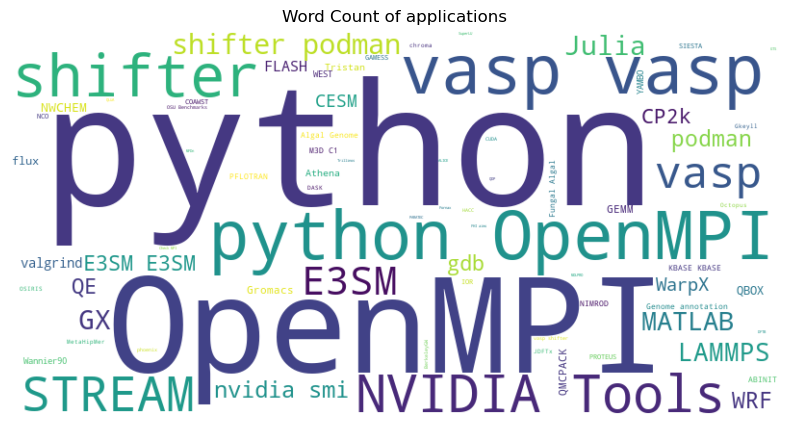

In [15]:
#Word Cloud Visuals 

# Combining all the matches into a single string
all_matches = ' '.join([' '.join(match) if isinstance(match, list) else match for match in filtered_data['Applications']])

# Generating the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_matches)

# Displaying the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Count of applications')
plt.show()




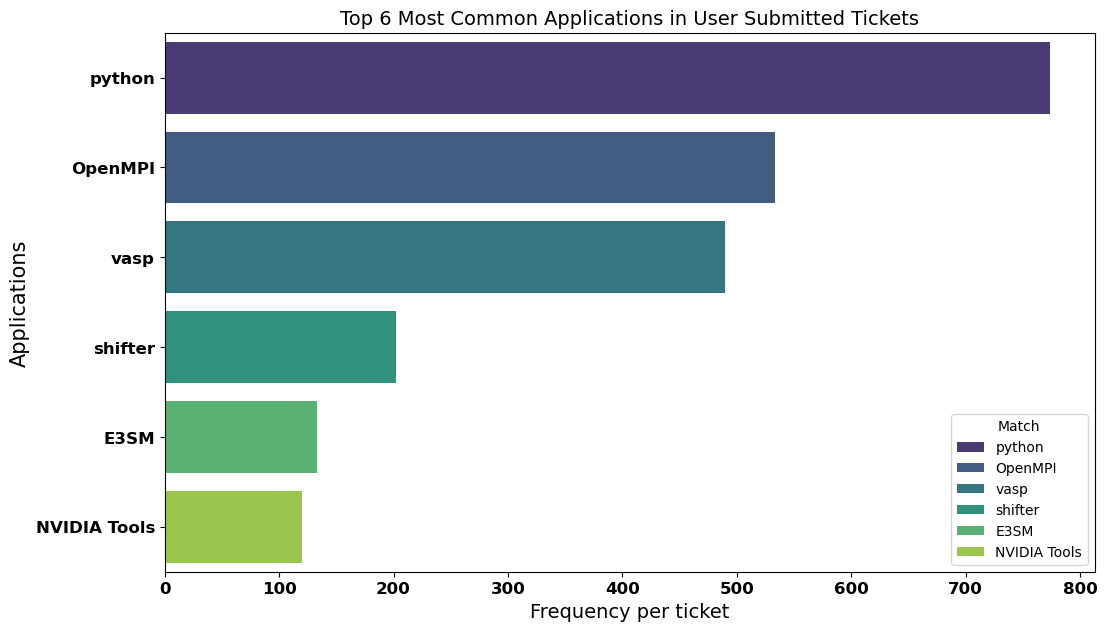

In [16]:
# Bar Plot of Most Common Applications

# Flatten the list of matches and count the occurrences of each match
flattened_matches = [match for sublist in filtered_data['Applications'] for match in (sublist if isinstance(sublist, list) else [sublist])]
match_counts = Counter(flattened_matches)

# Converting to a DataFrame for plotting
match_counts_df = pd.DataFrame(match_counts.items(), columns=['Match', 'Frequency']).sort_values(by='Frequency', ascending=False)

# Plot the top N most common words
N = 6
top_n_words = match_counts_df.head(N)

plt.figure(figsize=(12, 7))
sns.barplot(x='Frequency', y='Match', data=top_n_words, palette='viridis', hue='Match',legend=True, dodge=False)
plt.xlabel('Frequency per ticket', fontsize=14)
plt.ylabel('Applications', fontsize=15)
plt.title(f'Top {N} Most Common Applications in User Submitted Tickets',fontsize=14)
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.show()



In [17]:
#ISSUES

# 2D PREP
patterns2 = {
    "login": r"(?i)\blogin\b",
    "license": r"(?i)\blicense\b",
    "password": r"(?i)\bpassword\b",
    "error": r"(?i)\berror\b",
    "crash": r"(?i)\bcrash\b",
    "configuration": r"(?i)\bconfiguration\b",
    "backup": r"(?i)\bbackup\b",
    "restore": r"(?i)\brestore\b",
    "network outage": r"(?i)\bnetwork\boutage\b",
    "log-in": r"(?i)\blog-in\b",
    "activation": r"activation",
    "blocked": r"(?i)\bblocked\b",
    "locked": r"(?i)\blocked\b",
    "approval": r"(?i)\bapproval\b",
    "mfa": r"(?i)\bmfa\b",
    "quota": r"(?i)\bquota\b",  
    "connect": r"(?i)\bconnect\b",
    "compile": r"(?i)\bcompile\b",
    "link": r"(?i)\blink\b",
    "build": r"(?i)\bbuild\b",
    "make": r"(?i)\bmake\b",
    "timeout": r"(?i)\btimeout\b",
    "freeze": r"(?i)\bfreeze\b",
    "unresponsive": r"(?i)\bunresponsive\b",
    "lag": r"(?i)\blag\b",
    "broken": r"(?i)\bbroken\b",
    "request": r"(?i)\brequest\b",
    "module": r"(?i)\bmodule\b",
    "slow": r"(?i)\bslow\b",
    "profile": r"(?i)\bprofile\b",
    "performance": r"(?i)\bperformance\b",
    "libraries": r"(?i)\blibraries\b",
    "mpi": r"(?i)\bmpi\b",
    "job": r"(?i)\bjob\b",
    "parameter": r"(?i)\bparameter\b",
    "hang": r"(?i)\bhang\b",
    "certificate": r"(?i)\bcertificate\b",
    "automated": r"(?i)\bautomated\b",
    "documentation": r"(?i)\bdocumentation\b",
    "docs": r"(?i)\bdocs\b",
    "stop": r"(?i)\bstop\b",
    "wrong": r"(?i)\bwrong\b",
    "session": r"(?i)\bsession\b",
    "node": r"(?i)\bnode\b",
    "hpe": r"(?i)\bhpe\b",
    "wait": r"(?i)\bwait\b",
    "policy": r"(?i)\bpolicy\b",
    "queue": r"(?i)\bqueue\b",
    "permissions": r"(?i)\bpermissions\b",
    "mpich": r"(?i)\bmpich\b",
    "makefile": r"(?i)\bmakefile\b",
    "crontab": r"(?i)\bcrontab\b",
    "scrontab": r"(?i)\bscrontab\b",
    "disconnect": r"(?i)\bdisconnect\b",
    "user": r"(?i)\buser\b",
    "account": r"(?i)\baccount\b",
    "collab": r"(?i)\bcollab\b",
    "ssh": r"(?i)\bssh\b",
   # "closed": r"(?i)\bclosed\b",
    "save": r"(?i)\bsave\b",
    "processes": r"(?i)\bprocesses\b",
    "sharing": r"(?i)\bsharing\b",
    "CFS": r"(?i)\bCFS\b",
    "scratch": r"(?i)\bscratch\b",
    "executable": r"(?i)\bexecutable\b",
    "IO": r"(?i)\bIO\b",
    "CPU": r"(?i)\bCPU\b",
    "GPU": r"(?i)\bGPU\b",
    "intel": r"(?i)\bintel\b",
    "gnu": r"(?i)\bgnu\b",
    "nvidia": r"(?i)\bnvidia\b",
    "cray": r"(?i)\bcray\b",
    "file": r"(?i)\bfile\b",
    "qos": r"(?i)\bqos\b",
    "OS": r"(?i)\bOS\b",
    "shell": r"(?i)\bshell\b",
    "bash": r"(?i)\bbash\b",
    "csh": r"(?i)\bcsh\b",
    "tsh": r"(?i)\btsh\b",
    "ip": r"(?i)\bip\b",
    "compute": r"(?i)\bcompute\b",
    "workflow": r"(?i)\bworkflow\b",
    "memory": r"(?i)\bmemory\b",
    "utilization": r"(?i)\butilization\b",
    "data": r"(?i)\bdata\b",
    "application": r"(?i)\bapplication\b",
    "framework": r"(?i)\bframework\b",
    "realtime": r"(?i)\brealtime\b",
    "allocation": r"(?i)\ballocation\b",
    "reservation": r"(?i)\breservation\b",
    "slurm": r"(?i)\bslurm\b",
    "script": r"(?i)\bscript\b",
    "group": r"(?i)\bgroup\b",
    "membership": r"(?i)\bmembership\b",
    "create": r"(?i)\bcreate\b",
    "access": r"(?i)\baccess\b",
    "issue": r"(?i)\bissue\b",
    "source": r"(?i)\bsource\b"

    #"alloacation_year": r"\ballocation year\b"
}

compiled_patterns2 = {
    name: re.compile(pattern, re.IGNORECASE)
    for name, pattern in patterns2.items()
}

In [18]:
def match(string, patterns):
    issues = []
    for name, pattern in patterns.items():
        #print(name)
        #print(matches)
        if pattern.search(string):
            #print("found", name)
            issues.append(name) 
    return issues

def f(x):
    return match(x, compiled_patterns2)

In [19]:
%%time
names2 = process_map(f, data['text_data'], max_workers=32, chunksize=1000) #play with the numbers

  0%|          | 0/6944 [00:00<?, ?it/s]

CPU times: user 49.7 ms, sys: 386 ms, total: 436 ms
Wall time: 8.95 s


In [20]:
data = pd.DataFrame(data)

In [21]:
data.head()

,ID,Created,Applications,text_data
0,197129,2023-01-18 10:33:43,[],103343 add another majorana project user permi...
1,197134,2023-01-18 11:11:14,[],111114 can't edit qos information 020036 - sys...
2,197136,2023-01-18 11:13:15,[],111315 save qos information previous year 0200...
3,197138,2023-01-18 11:15:50,[OpenMPI],"111550 ability sort ""confirm users"" table ""wil..."
4,197145,2023-01-18 12:04:41,[],120441 m3514 re-allocation 020037 - system (ad...


In [22]:
data.insert(2,"Issues",names2,True)

In [23]:
#data

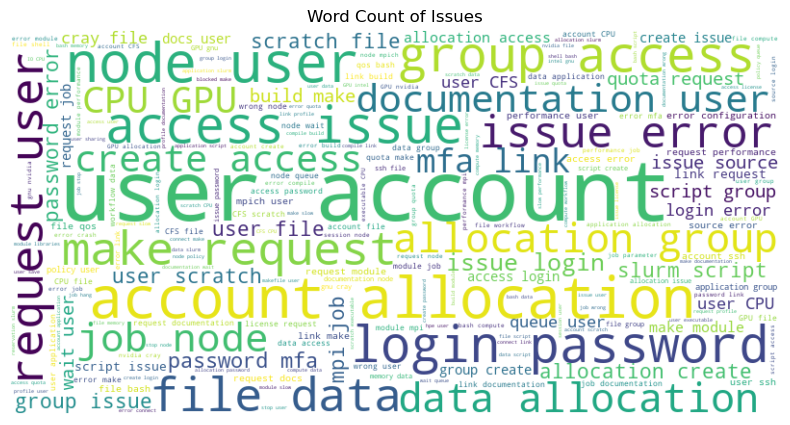

In [24]:
#Word Cloud Visuals 

# Combining all the matches into a single string
all_matches = ' '.join([' '.join(match) if isinstance(match, list) else match for match in data['Issues']])

# Generating the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_matches)

# Displaying the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Count of Issues')
plt.show()



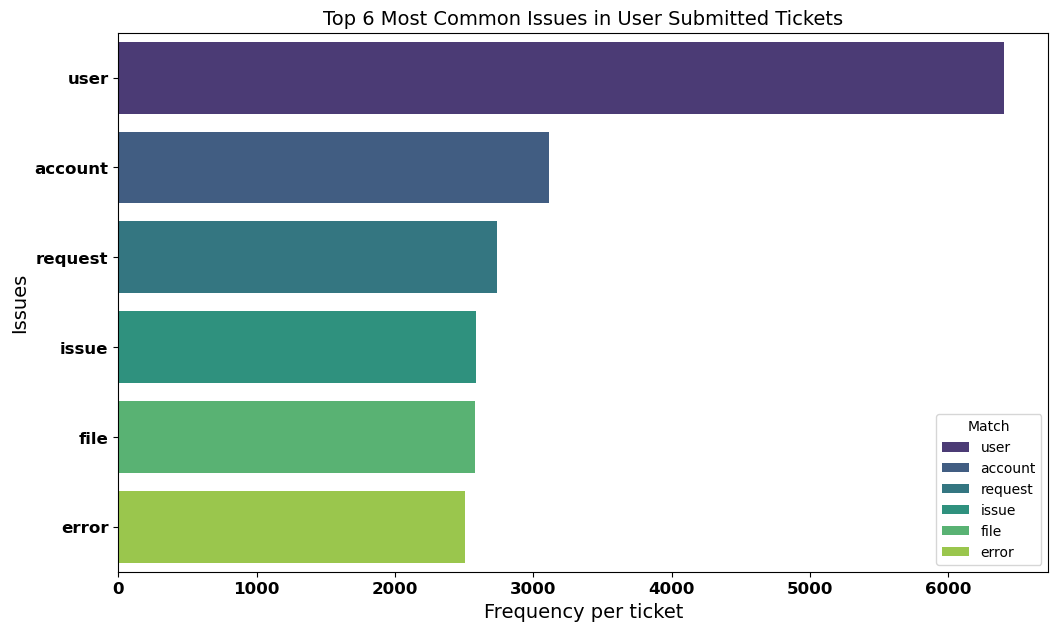

In [25]:
# Bar Plot of Most Common Words

# Flatten the list of matches and count the occurrences of each match
flattened_matches = [match for sublist in data['Issues'] for match in (sublist if isinstance(sublist, list) else [sublist])]
match_counts = Counter(flattened_matches)

# Converting to a DataFrame for plotting
match_counts_df = pd.DataFrame(match_counts.items(), columns=['Match', 'Frequency']).sort_values(by='Frequency', ascending=False)

# Plot the top N most common words
N = 6
top_n_words = match_counts_df.head(N)

plt.figure(figsize=(12, 7))
sns.barplot(x='Frequency', y='Match', data=top_n_words, palette='viridis', hue='Match',legend=True, dodge=False)
plt.xlabel('Frequency per ticket',fontsize=14)
plt.ylabel('Issues', fontsize=14)
plt.title(f'Top {N} Most Common Issues in User Submitted Tickets', fontsize=14)
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.show()


In [26]:
data.to_csv('/global/u2/m/masare/ticket-text-analysis/backup.csv', index=False)
#data_df = pd.read_csv('/global/u2/m/masare/ticket-text-analysis/Ticket.csv')

In [27]:

#filter out empty matches
filtered_data = data[data['Applications'] != '']

applications_keywords = [match for sublist in filtered_data['Applications'] for match in (sublist if isinstance(sublist, list) else [sublist])]
issues_keywords = flattened_matches = [match for sublist in data['Issues'] for match in (sublist if isinstance(sublist, list) else [sublist])]

In [28]:
issues_counts = data['Issues'].apply(Counter)
#issues_counts

In [29]:
apps_counts = data['Applications'].apply(Counter)
#apps_counts

In [30]:
issues_df =pd.DataFrame.from_records(issues_counts).fillna(0).astype(int)
apps_df =pd.DataFrame.from_records(apps_counts).fillna(0).astype(int)

In [31]:
issues_df['ID'] = data['ID']
apps_df['ID'] = data['ID']

In [32]:
issues_df.set_index('ID', inplace=True)
#issues_df

In [33]:
apps_df.set_index('ID', inplace=True)
#apps_df

In [34]:
###Functions. I had to continue here because the regex matched words  were not showing

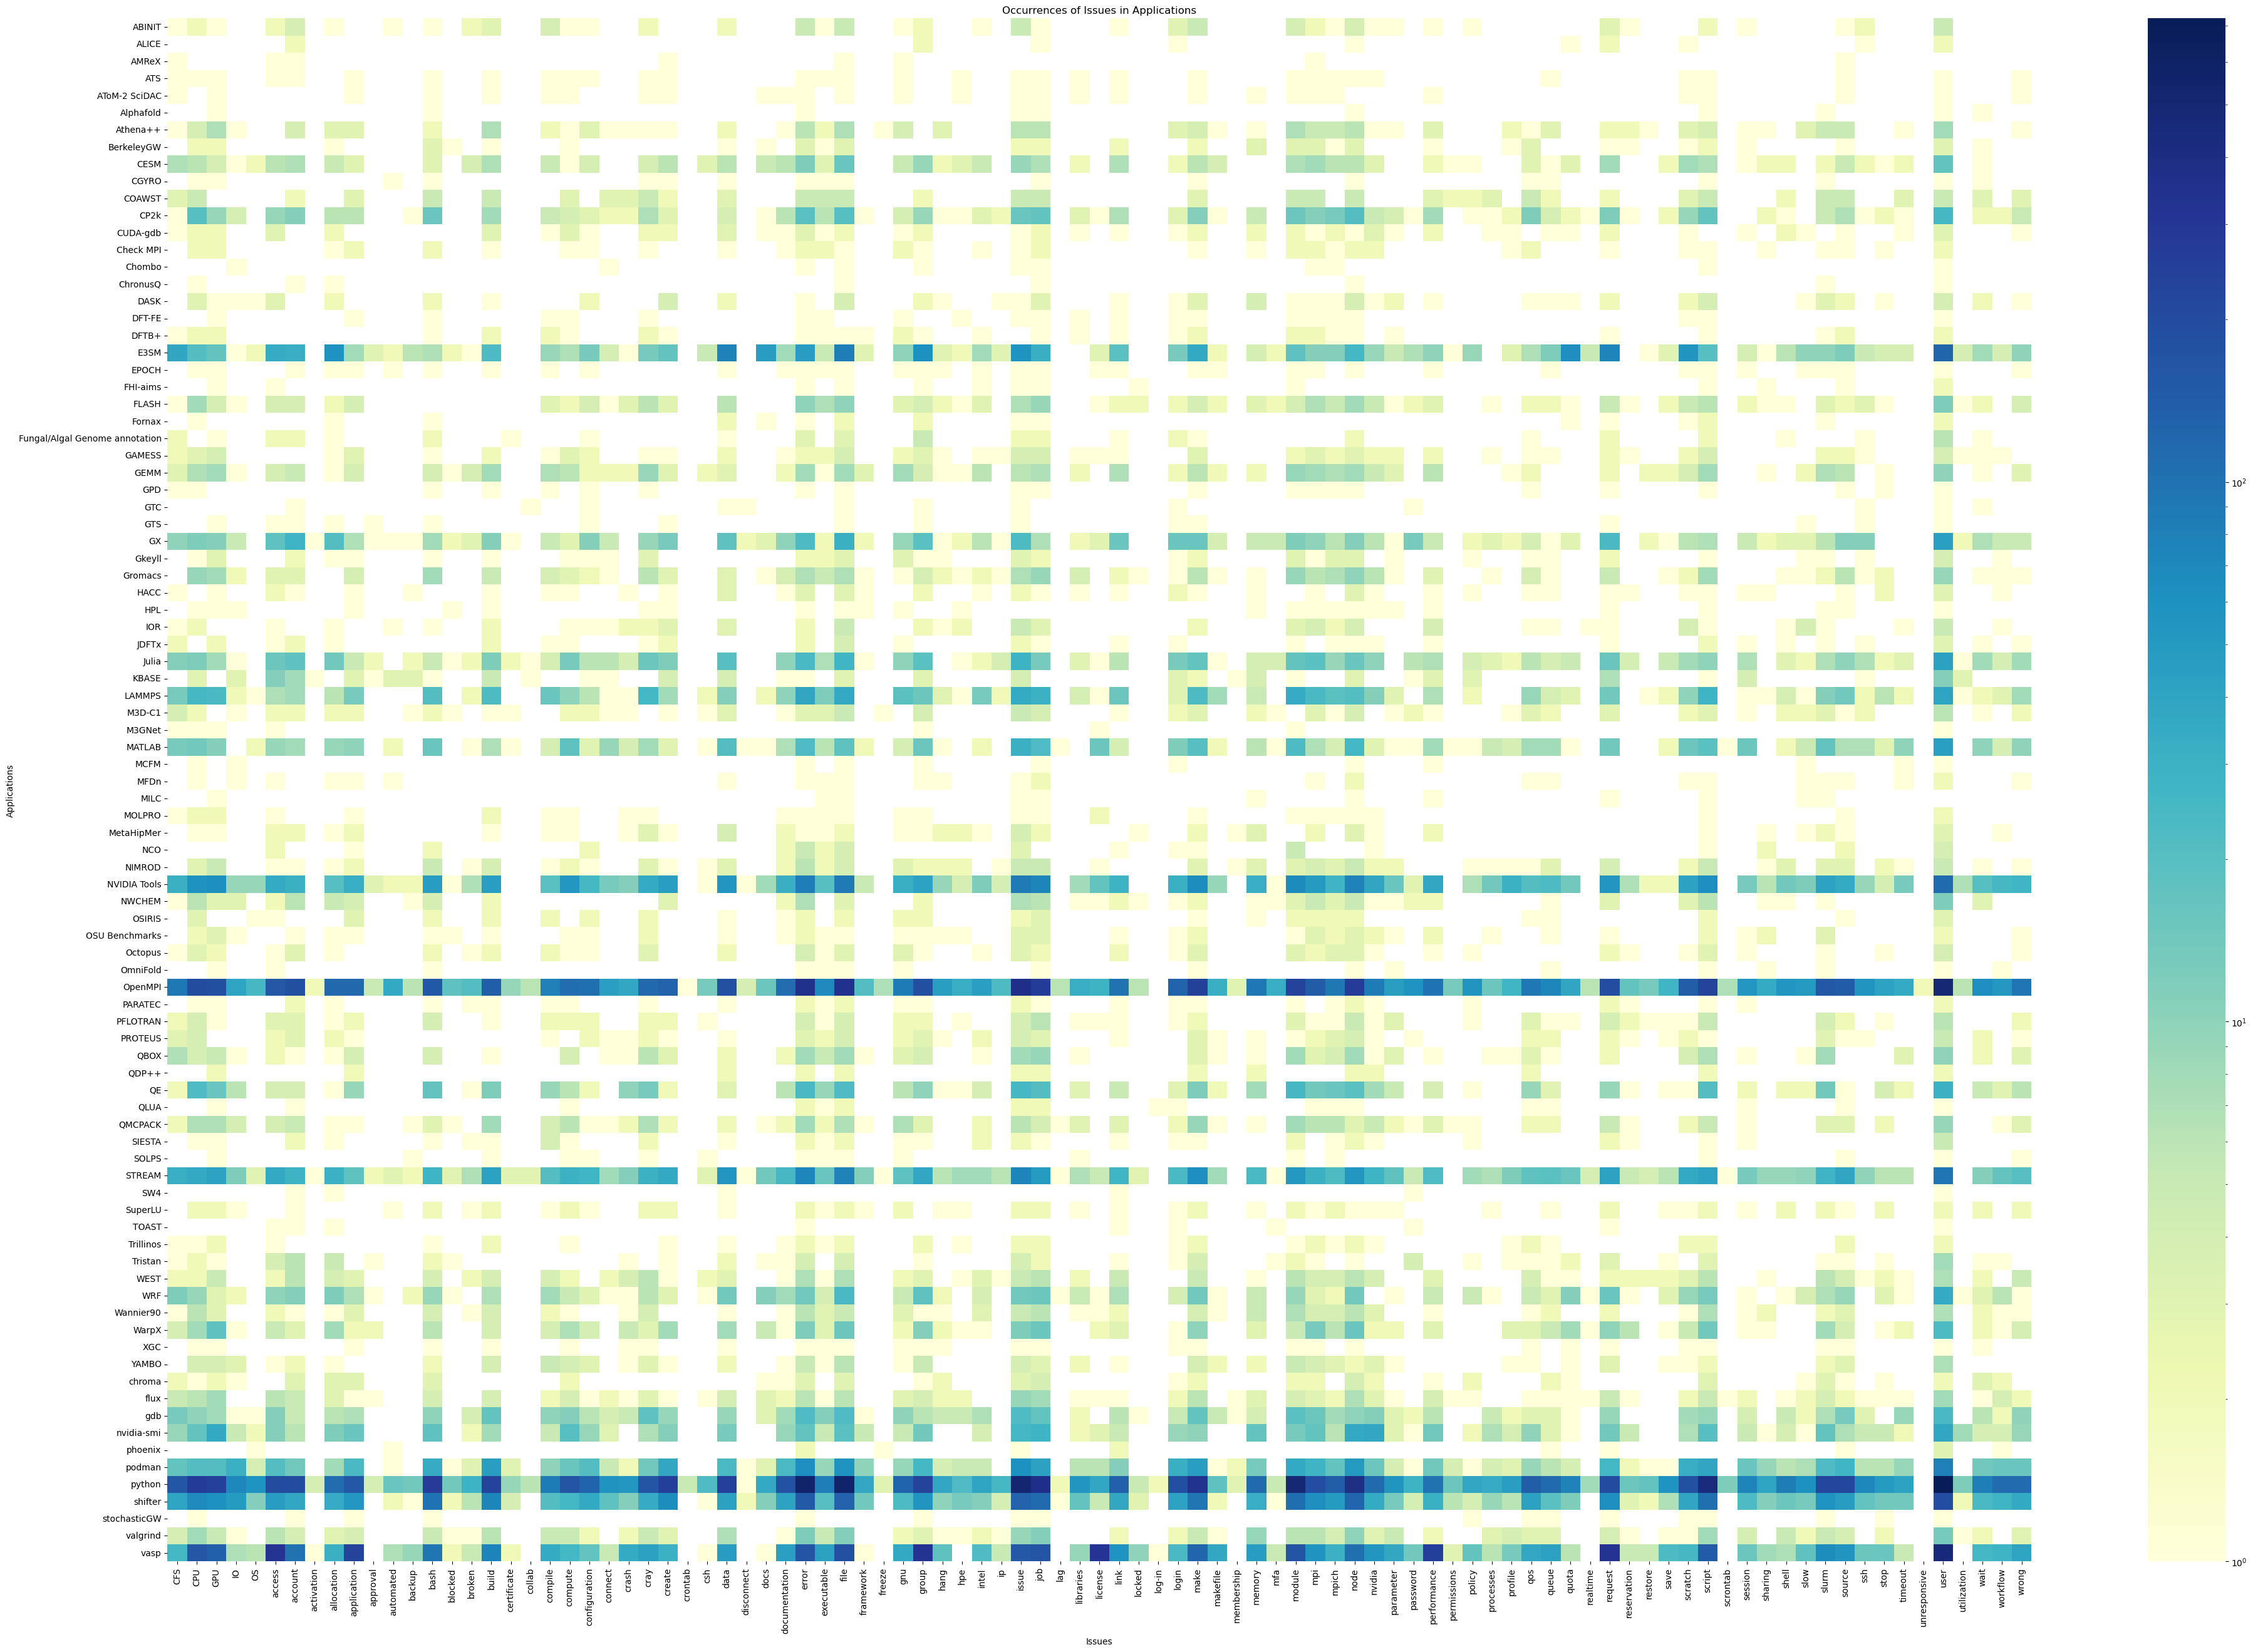

In [35]:
# Flatten the issues and applications into a list of tuples (app, issue) and count occurrences
import matplotlib.colors
counts = []
for idx, row in data.iterrows():
    apps = row['Applications']
    issues = row['Issues']
    for app in apps:
        for issue in issues:
            counts.append((app, issue))


#  counts to a DataFrame
counts_df = pd.DataFrame(counts, columns=['Application', 'Issue'])
counts_matrix = counts_df.groupby(['Application', 'Issue']).size().unstack(fill_value=0)


def plot_heatmap(matrix):
    """
    Plots a heatmap for the given matrix.
    
    Parameters:
    matrix (pd.DataFrame): DataFrame representing the 2D matrix.
    """
    plt.figure(figsize=(48, 32))
    sns.heatmap(matrix, annot=False, fmt="d", cmap="YlGnBu", norm=matplotlib.colors.LogNorm())
    plt.title("Occurrences of Issues in Applications")
    plt.xlabel("Issues")
    plt.ylabel("Applications")
    plt.show()


# Plot the heatmap
plot_heatmap(counts_matrix)


In [36]:
#counts_matrix

In [37]:
#counts_df

In [38]:
# Find the maximum and minimum entries in the matrix
max_value = counts_matrix.max().max()
min_value = counts_matrix.min().min()


# Find the positions of the maximum and minimum values
max_position = counts_matrix.stack().idxmax()
min_position = counts_matrix.stack().idxmin()


print(f"Maximum value: {max_value} at position: {max_position}")
print(f"Minimum value: {min_value} at position: {min_position}")


Maximum value: 722 at position: ('python', 'user')
Minimum value: 0 at position: ('ABINIT', 'IO')


In [39]:
# Find the row with the maximum sum of entries
row_sums = counts_matrix.sum(axis=1)
max_row_sum = row_sums.max()
max_row = row_sums.idxmax()


print(f"Row with the maximum sum: {max_row} with a sum of {max_row_sum}")


Row with the maximum sum: python with a sum of 11755


In [40]:
# Find the row with the minimum sum of entries
min_row_sum = row_sums.min()
min_row = row_sums.idxmin()


print(f"Row with the minimum sum: {min_row} with a sum of {min_row_sum}")


Row with the minimum sum: SW4 with a sum of 6


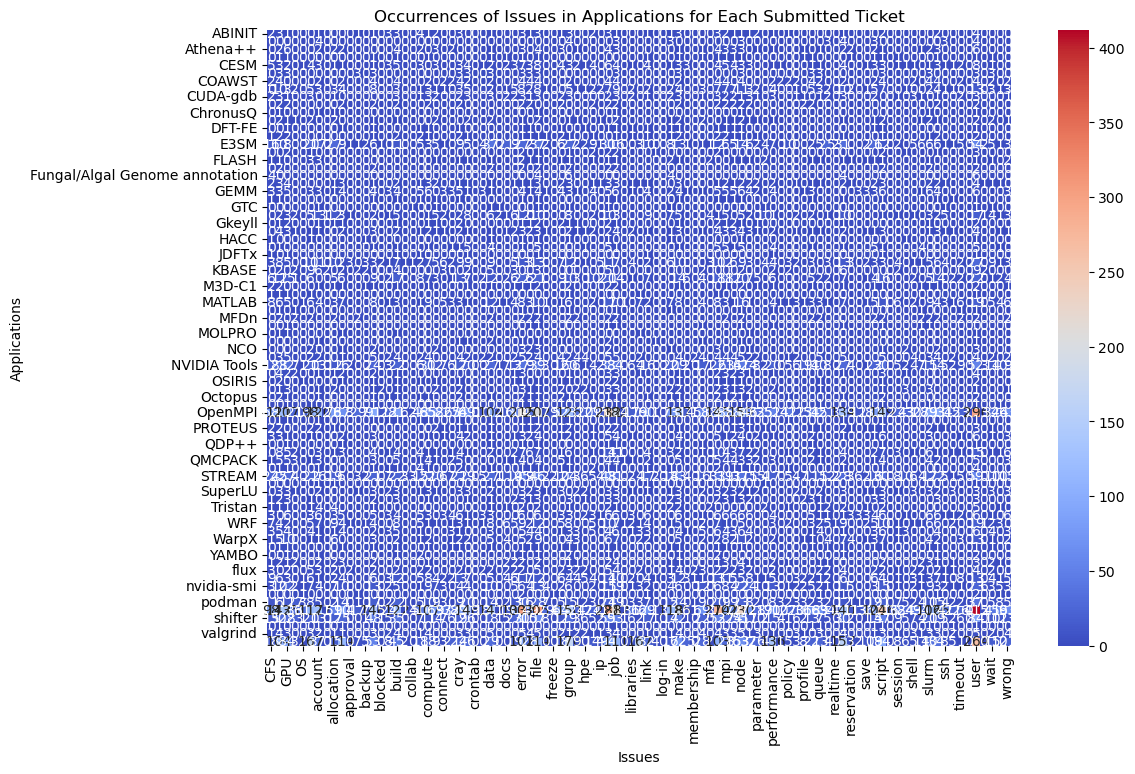

In [41]:
###Sample of 30

data_sample = data.sample(n=4000, replace=True, random_state=1)


# Flatten the issues and applications into a list of tuples (app, issue) and count occurrences
counts = []
for idx, row in data_sample.iterrows():
    apps = row['Applications']
    issues = row['Issues']
    for app in apps:
        for issue in issues:
            counts.append((app, issue))


# Convert the counts to a DataFrame
counts_df = pd.DataFrame(counts, columns=['Application', 'Issue'])
counts_matrix = counts_df.groupby(['Application', 'Issue']).size().unstack(fill_value=0)


def plot_heatmap(matrix):
    """
    Plots a heatmap for the given matrix.
    
    Parameters:
    matrix (pd.DataFrame): DataFrame representing the 2D matrix.
    """
    plt.figure(figsize=(12, 8))
    sns.heatmap(matrix, annot=True, fmt="d", cmap="coolwarm")
    plt.title("Occurrences of Issues in Applications for Each Submitted Ticket")
    plt.xlabel("Issues")
    plt.ylabel("Applications")
    plt.show()


# Plot the heatmap
plot_heatmap(counts_matrix)


In [42]:
# Find the row with the maximum sum of entries
row_sums = counts_matrix.sum(axis=1)
max_row_sum = row_sums.max()
max_row = row_sums.idxmax()


print(f"Row with the maximum sum: {max_row} with a sum of {max_row_sum}")


# Find the row with the minimum sum of entries
min_row_sum = row_sums.min()
min_row = row_sums.idxmin()


print(f"Row with the minimum sum: {min_row} with a sum of {min_row_sum}")


Row with the maximum sum: python with a sum of 6711
Row with the minimum sum: SW4 with a sum of 6


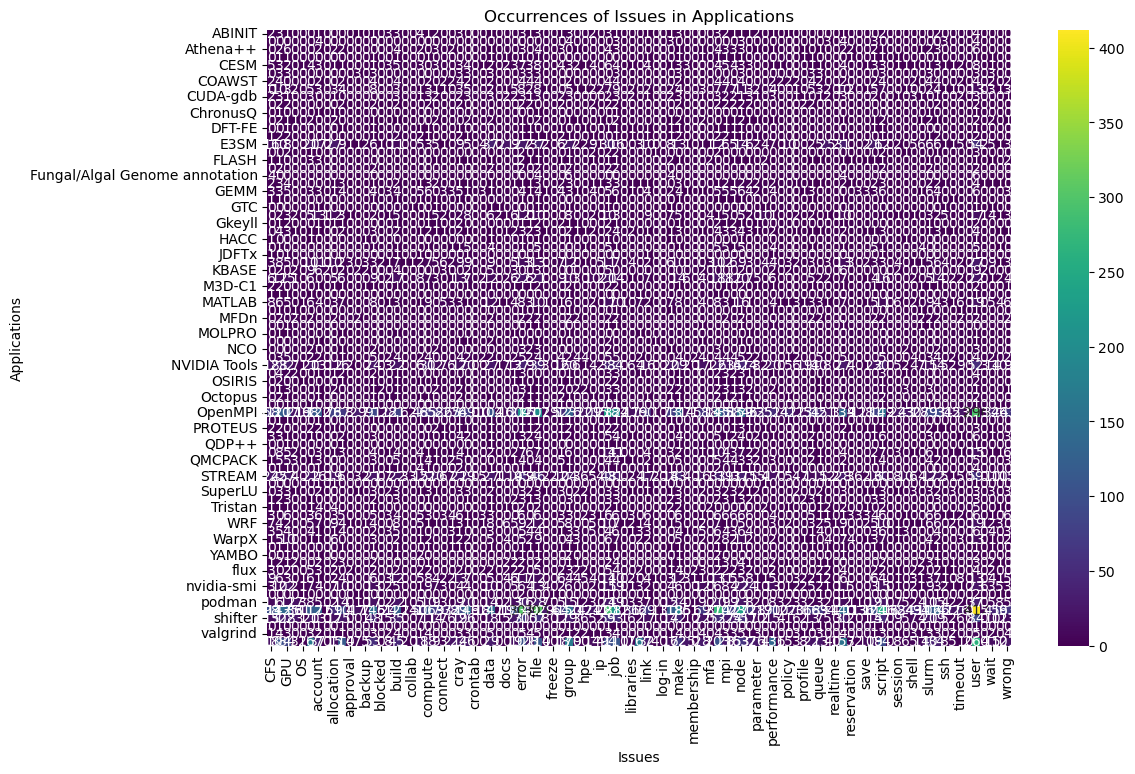

In [43]:
# Filter out zero entries
counts_matrix_filtered = counts_matrix.loc[:, (counts_matrix != 0).any(axis=0)]
counts_matrix_filtered = counts_matrix_filtered.loc[(counts_matrix_filtered != 0).any(axis=1), :]


def plot_heatmap(matrix):
    """
    Plots a heatmap for the given matrix.
    
    Parameters:
    matrix (pd.DataFrame): DataFrame representing the 2D matrix.
    """
    plt.figure(figsize=(12, 8))
    sns.heatmap(matrix, annot=True, fmt="d", cmap="viridis")
    plt.title("Occurrences of Issues in Applications")
    plt.xlabel("Issues")
    plt.ylabel("Applications")
    plt.show()


# Plot the heatmap
plot_heatmap(counts_matrix_filtered)


In [44]:
# Find the row with the maximum sum of entries
row_sums = counts_matrix_filtered.sum(axis=1)
max_row_sum = row_sums.max()
max_row = row_sums.idxmax()


print(f"Row with the maximum sum: {max_row} with a sum of {max_row_sum}")


# Find the column with the maximum sum of entries
col_sums = counts_matrix_filtered.sum(axis=0)
max_col_sum = col_sums.max()
max_col = col_sums.idxmax()


print(f"Column with the maximum sum: {max_col} with a sum of {max_col_sum}")



Row with the maximum sum: python with a sum of 6711
Column with the maximum sum: user with a sum of 1613


In [45]:
counts_matrix_filtered

Issue,CFS,CPU,GPU,IO,OS,access,account,activation,allocation,application,approval,automated,backup,bash,blocked,broken,build,certificate,collab,compile,compute,configuration,connect,crash,cray,create,crontab,csh,data,disconnect,docs,documentation,error,executable,file,framework,freeze,gnu,group,hang,hpe,intel,ip,issue,job,lag,libraries,license,link,locked,log-in,login,make,makefile,membership,memory,mfa,module,mpi,mpich,node,nvidia,parameter,password,performance,permissions,policy,processes,profile,qos,queue,quota,realtime,request,reservation,restore,save,scratch,script,scrontab,session,sharing,shell,slow,slurm,source,ssh,stop,timeout,unresponsive,user,utilization,wait,workflow,wrong
Application,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
ABINIT,2,3,1,0,0,0,1,0,0,0,0,1,0,1,0,3,3,0,0,4,1,2,0,0,3,0,0,0,1,0,0,0,3,1,3,0,0,1,3,0,0,2,0,3,1,0,0,0,1,0,0,1,3,0,0,0,0,3,2,1,1,1,2,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,2,0,0,0,0,0,0,2,0,0,0,0,4,0,0,0,0
ALICE,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,3,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,3,0,4,0,0,0,3,0,0,0,0,0,0,0,0,3,0,0,0,4,0,0,0,0
Athena++,0,2,6,0,0,0,2,0,2,2,0,0,0,0,0,0,4,0,0,2,0,3,0,2,0,0,0,0,1,0,0,0,3,0,4,0,0,3,0,1,0,0,0,4,3,0,0,0,0,0,0,0,1,0,0,1,0,4,3,3,3,0,1,0,1,0,0,0,1,0,1,0,0,2,2,0,0,2,1,0,0,0,0,1,2,3,0,0,0,0,6,0,0,0,0
BerkeleyGW,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,1,1,1,1,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,1,1,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0
CESM,5,3,2,0,1,4,3,0,1,1,0,0,0,1,0,3,5,0,0,3,0,3,0,0,3,4,0,1,2,0,2,3,7,3,8,0,0,4,3,2,1,4,0,6,4,0,1,0,4,0,0,1,3,3,0,0,0,4,5,4,3,3,0,0,1,1,0,0,0,1,1,0,0,4,0,0,1,3,3,0,1,1,1,0,1,3,1,1,2,0,8,0,1,0,0
CGYRO,0,3,3,0,0,0,0,0,0,0,0,3,0,3,0,0,0,0,0,0,0,0,0,0,3,3,0,0,3,0,0,0,3,3,3,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,3,3,0,0,0,0,0,0,0,3,0,0,0,0,0,3,0,0,0,0,0,3,0,3,0,0
COAWST,2,4,0,0,0,0,2,0,0,2,0,0,0,4,0,0,4,0,0,0,2,0,2,2,4,2,0,0,2,0,0,0,4,4,4,0,0,0,2,0,0,0,0,4,4,0,0,0,0,0,0,0,2,0,0,0,0,4,4,0,4,0,0,0,2,2,2,2,0,4,2,0,0,2,0,0,0,2,4,0,0,0,2,0,4,4,0,0,2,0,4,0,2,0,2
CP2k,0,10,3,2,0,5,3,0,3,4,0,0,0,8,0,0,3,0,0,1,3,1,1,0,3,5,0,0,2,0,1,5,8,2,8,1,0,0,5,1,1,2,2,7,9,0,2,0,2,0,0,2,4,0,0,3,0,7,7,7,11,3,2,0,4,0,0,1,0,5,3,2,0,10,2,0,1,5,7,0,0,1,0,0,2,4,1,1,0,0,13,0,3,1,3
CUDA-gdb,2,3,1,0,0,3,0,0,1,0,0,0,0,0,0,0,3,0,0,1,3,2,0,0,2,3,0,0,3,0,2,2,3,1,3,0,0,2,3,0,0,0,0,2,3,0,2,0,1,0,0,2,3,0,0,1,0,3,2,2,1,3,1,0,3,0,0,1,1,0,1,2,0,3,0,0,0,2,0,0,1,0,3,1,0,1,0,0,2,0,3,0,0,0,1


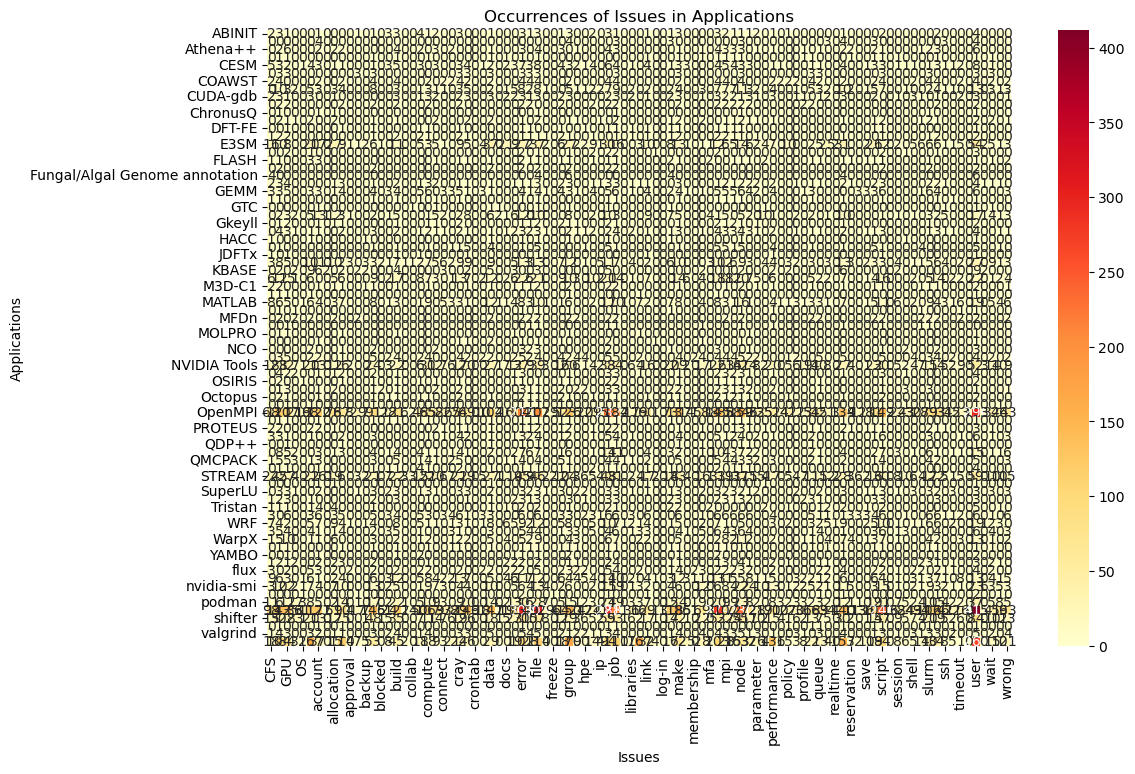

Row with the maximum sum: python with a sum of 6711
Column with the maximum sum: user with a sum of 1613


In [46]:

data_sample = data.sample(n=30, replace=True, random_state=1)
# Filter out zero entries
counts_matrix_filtered = counts_matrix.loc[:, (counts_matrix != 0).any(axis=0)]
counts_matrix_filtered = counts_matrix_filtered.loc[(counts_matrix_filtered != 0).any(axis=1), :]


def plot_heatmap(matrix):
    """
    Plots a heatmap for the given matrix.
    
    Parameters:
    matrix (pd.DataFrame): DataFrame representing the 2D matrix.
    """
    plt.figure(figsize=(12, 8))
    sns.heatmap(matrix, annot=True, fmt="d", cmap="YlOrRd")
    plt.title("Occurrences of Issues in Applications")
    plt.xlabel("Issues")
    plt.ylabel("Applications")
    plt.show()


# Plot the heatmap
plot_heatmap(counts_matrix_filtered)


# Find the row with the maximum sum of entries
row_sums = counts_matrix_filtered.sum(axis=1)
max_row_sum = row_sums.max()
max_row = row_sums.idxmax()


print(f"Row with the maximum sum: {max_row} with a sum of {max_row_sum}")


# Find the column with the maximum sum of entries
col_sums = counts_matrix_filtered.sum(axis=0)
max_col_sum = col_sums.max()
max_col = col_sums.idxmax()


print(f"Column with the maximum sum: {max_col} with a sum of {max_col_sum}")




In [47]:
counts_matrix_filtered

Issue,CFS,CPU,GPU,IO,OS,access,account,activation,allocation,application,approval,automated,backup,bash,blocked,broken,build,certificate,collab,compile,compute,configuration,connect,crash,cray,create,crontab,csh,data,disconnect,docs,documentation,error,executable,file,framework,freeze,gnu,group,hang,hpe,intel,ip,issue,job,lag,libraries,license,link,locked,log-in,login,make,makefile,membership,memory,mfa,module,mpi,mpich,node,nvidia,parameter,password,performance,permissions,policy,processes,profile,qos,queue,quota,realtime,request,reservation,restore,save,scratch,script,scrontab,session,sharing,shell,slow,slurm,source,ssh,stop,timeout,unresponsive,user,utilization,wait,workflow,wrong
Application,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
ABINIT,2,3,1,0,0,0,1,0,0,0,0,1,0,1,0,3,3,0,0,4,1,2,0,0,3,0,0,0,1,0,0,0,3,1,3,0,0,1,3,0,0,2,0,3,1,0,0,0,1,0,0,1,3,0,0,0,0,3,2,1,1,1,2,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,2,0,0,0,0,0,0,2,0,0,0,0,4,0,0,0,0
ALICE,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,3,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,3,0,4,0,0,0,3,0,0,0,0,0,0,0,0,3,0,0,0,4,0,0,0,0
Athena++,0,2,6,0,0,0,2,0,2,2,0,0,0,0,0,0,4,0,0,2,0,3,0,2,0,0,0,0,1,0,0,0,3,0,4,0,0,3,0,1,0,0,0,4,3,0,0,0,0,0,0,0,1,0,0,1,0,4,3,3,3,0,1,0,1,0,0,0,1,0,1,0,0,2,2,0,0,2,1,0,0,0,0,1,2,3,0,0,0,0,6,0,0,0,0
BerkeleyGW,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,1,1,1,1,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,1,1,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0
CESM,5,3,2,0,1,4,3,0,1,1,0,0,0,1,0,3,5,0,0,3,0,3,0,0,3,4,0,1,2,0,2,3,7,3,8,0,0,4,3,2,1,4,0,6,4,0,1,0,4,0,0,1,3,3,0,0,0,4,5,4,3,3,0,0,1,1,0,0,0,1,1,0,0,4,0,0,1,3,3,0,1,1,1,0,1,3,1,1,2,0,8,0,1,0,0
CGYRO,0,3,3,0,0,0,0,0,0,0,0,3,0,3,0,0,0,0,0,0,0,0,0,0,3,3,0,0,3,0,0,0,3,3,3,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,3,3,0,0,0,0,0,0,0,3,0,0,0,0,0,3,0,0,0,0,0,3,0,3,0,0
COAWST,2,4,0,0,0,0,2,0,0,2,0,0,0,4,0,0,4,0,0,0,2,0,2,2,4,2,0,0,2,0,0,0,4,4,4,0,0,0,2,0,0,0,0,4,4,0,0,0,0,0,0,0,2,0,0,0,0,4,4,0,4,0,0,0,2,2,2,2,0,4,2,0,0,2,0,0,0,2,4,0,0,0,2,0,4,4,0,0,2,0,4,0,2,0,2
CP2k,0,10,3,2,0,5,3,0,3,4,0,0,0,8,0,0,3,0,0,1,3,1,1,0,3,5,0,0,2,0,1,5,8,2,8,1,0,0,5,1,1,2,2,7,9,0,2,0,2,0,0,2,4,0,0,3,0,7,7,7,11,3,2,0,4,0,0,1,0,5,3,2,0,10,2,0,1,5,7,0,0,1,0,0,2,4,1,1,0,0,13,0,3,1,3
CUDA-gdb,2,3,1,0,0,3,0,0,1,0,0,0,0,0,0,0,3,0,0,1,3,2,0,0,2,3,0,0,3,0,2,2,3,1,3,0,0,2,3,0,0,0,0,2,3,0,2,0,1,0,0,2,3,0,0,1,0,3,2,2,1,3,1,0,3,0,0,1,1,0,1,2,0,3,0,0,0,2,0,0,1,0,3,1,0,1,0,0,2,0,3,0,0,0,1


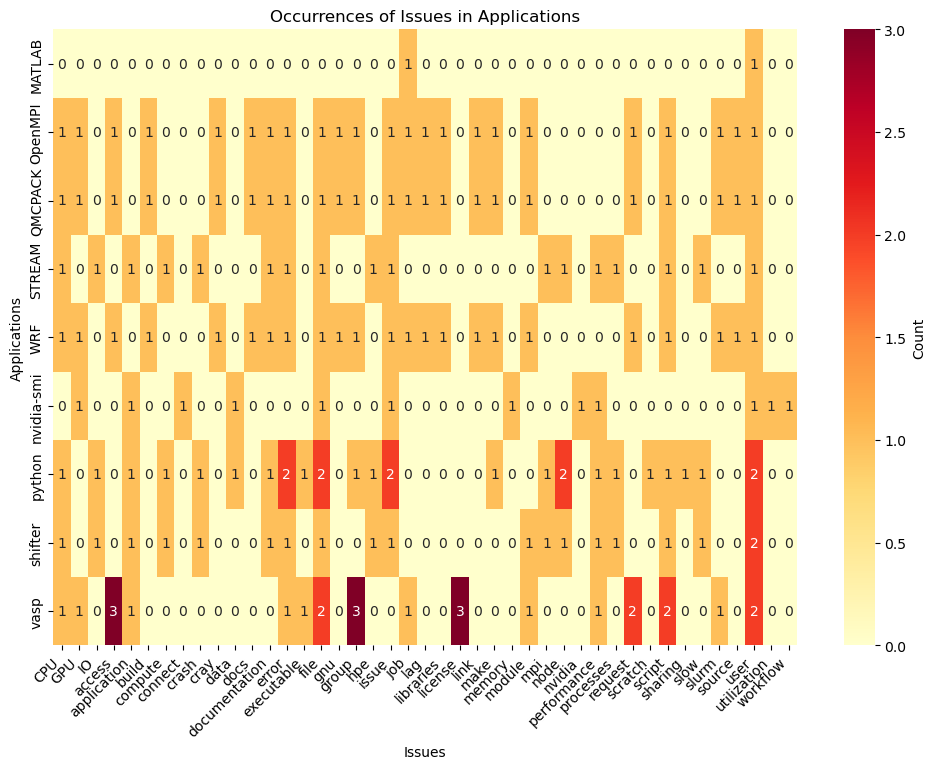

Row with the maximum sum: python with a sum of 28
Column with the maximum sum: user with a sum of 12


In [48]:


data_sample = data.sample(n=40, replace=True, random_state=1)


# Flatten the issues and applications into a list of tuples (app, issue) and count occurrences
counts = []
for idx, row in data_sample.iterrows():
    apps = row['Applications']
    issues = row['Issues']
    for app in apps:
        for issue in issues:
            counts.append((app, issue))


# Convert the counts to a DataFrame
counts_df = pd.DataFrame(counts, columns=['Application', 'Issue'])
counts_matrix = counts_df.groupby(['Application', 'Issue']).size().unstack(fill_value=0)


# Filter out zero entries
counts_matrix_filtered = counts_matrix.loc[:, (counts_matrix != 0).any(axis=0)]
counts_matrix_filtered = counts_matrix_filtered.loc[(counts_matrix_filtered != 0).any(axis=1), :]


def plot_heatmap(matrix):
    """
    Plots a heatmap for the given matrix.
    
    Parameters:
    matrix (pd.DataFrame): DataFrame representing the 2D matrix.
    """
    plt.figure(figsize=(12, 8))
    sns.heatmap(matrix, annot=True, fmt="d", cmap="YlOrRd", cbar_kws={'label': 'Count'})
    plt.title("Occurrences of Issues in Applications")
    plt.xlabel("Issues")
    plt.ylabel("Applications")
    plt.xticks(rotation=45, ha='right')
    plt.show()


# Plot the heatmap
plot_heatmap(counts_matrix_filtered)


# Find the row with the maximum sum of entries
row_sums = counts_matrix_filtered.sum(axis=1)
max_row_sum = row_sums.max()
max_row = row_sums.idxmax()


print(f"Row with the maximum sum: {max_row} with a sum of {max_row_sum}")


# Find the column with the maximum sum of entries
col_sums = counts_matrix_filtered.sum(axis=0)
max_col_sum = col_sums.max()
max_col = col_sums.idxmax()


print(f"Column with the maximum sum: {max_col} with a sum of {max_col_sum}")




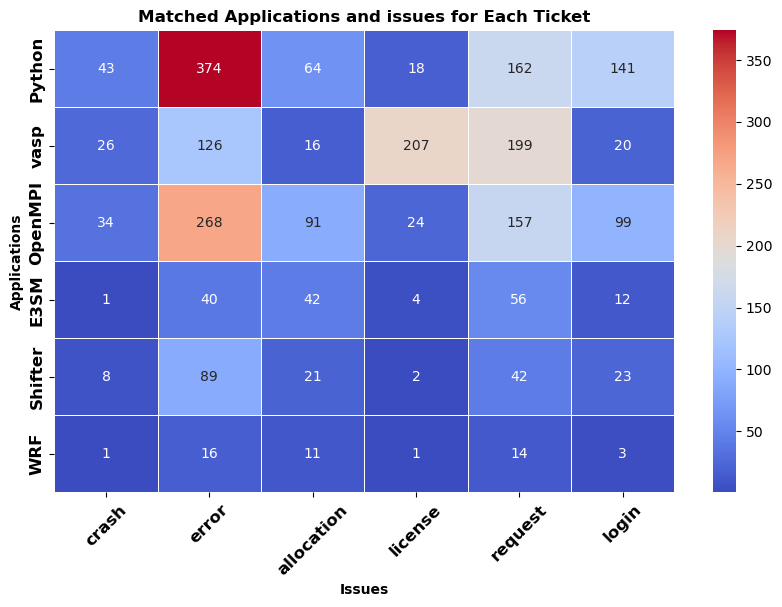

In [49]:
#poster
dt = {
    'crash': [43,26,34,1,8,1],
    'error': [374,126,268,40,89,16],
    'allocation': [64,16,91,42,21,11],
    'license': [18,207,24,4,2,1],
    'request': [162,199,157,56,42,14],
    'login': [141,20,99,12,23,3],
    'Application': ['Python','vasp', 'OpenMPI', 'E3SM', 'Shifter', 'WRF']
}


# Create DataFrame
df = pd.DataFrame(dt)
df.set_index('Application', inplace=True)


import seaborn as sns
import matplotlib.pyplot as plt


# Create a heatmap
plt.figure(figsize=(10, 6))  #  size of the figure
sns.heatmap(df, annot=True, cmap='coolwarm', fmt='d',linewidths=0.5)
plt.title('Matched Applications and issues for Each Ticket', fontweight='bold')
plt.xlabel('Issues', fontweight='bold')
plt.ylabel('Applications', fontweight='bold')
plt.xticks(fontsize=12, fontweight='bold', rotation=45)
plt.yticks(fontsize=12, fontweight='bold')
plt.show()




In [50]:
matrix = df.values

In [51]:
matrix

array([[ 43, 374,  64,  18, 162, 141],
       [ 26, 126,  16, 207, 199,  20],
       [ 34, 268,  91,  24, 157,  99],
       [  1,  40,  42,   4,  56,  12],
       [  8,  89,  21,   2,  42,  23],
       [  1,  16,  11,   1,  14,   3]])